<a href="https://colab.research.google.com/github/otavio-r-filho/nasa_space_apps/blob/master/notebooks/analise_fatorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASA Space Apps 2020: COVID-19 Challenge

In [0]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

plt.style.use("ggplot")

# Package that we may not have
# -----------------------------------------------
# Factory Analyzer
try:
  from factor_analyzer import FactorAnalyzer
  from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
  from factor_analyzer.factor_analyzer import calculate_kmo
except ModuleNotFoundError:
  !pip install factor_analyzer

try:
  import missingno as mso
except ModuleNotFoundError:
  !pip install missingno
# -----------------------------------------------

In [0]:
dados_tratados = glob("../data/external/*.csv")

In [239]:
# Google Colab POG
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Hackatons/NASA Space Apps 2020"
dados_tratados = glob("Data/Tratados/*.csv")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/148cbL0D25RHhLY_77tnnCNRdM-ul_EOK/NASA Space Apps 2020


## Databases consolidation

### Listing raw datasets

In [240]:
fnames = list(map(os.path.basename, dados_tratados))
wlength = np.max(list(map(len,fnames)))
dados_tratados = dict(zip(fnames, dados_tratados))
dataframes = dict()
for k,v in dados_tratados.items():
  print((k+":").rjust(wlength), v)

                            IDH.csv: Data/Tratados/IDH.csv
REAL_GDP_PER_CAPITA_CONSTANT_US$.csv: Data/Tratados/REAL_GDP_PER_CAPITA_CONSTANT_US$.csv
                   AGUA_TRATADA.csv: Data/Tratados/AGUA_TRATADA.csv
                  BASIC_HYGIENE.csv: Data/Tratados/BASIC_HYGIENE.csv
                      DESASTRES.csv: Data/Tratados/DESASTRES.csv
                  HOSPITAL_BEDS.csv: Data/Tratados/HOSPITAL_BEDS.csv
                   IMMUNIZATION.csv: Data/Tratados/IMMUNIZATION.csv
                    LOCAL_X_USD.csv: Data/Tratados/LOCAL_X_USD.csv
                        MEDICOS.csv: Data/Tratados/MEDICOS.csv
                OPEN_DEFECATION.csv: Data/Tratados/OPEN_DEFECATION.csv
                      POPULACAO.csv: Data/Tratados/POPULACAO.csv
                 REDE_DE_ESGOTO.csv: Data/Tratados/REDE_DE_ESGOTO.csv
                 SALARIO_MINIMO.csv: Data/Tratados/SALARIO_MINIMO.csv
                 IMMUNIZATION_2.csv: Data/Tratados/IMMUNIZATION_2.csv
                 IMMUNIZATION_3.csv: 

#### Number of inhabitants (2010 only)

In [241]:
df_populacao = pd.read_csv(dados_tratados["POPULACAO.csv"])
df_populacao = df_populacao.sort_values(["Year","Country Code"]).drop_duplicates(subset=["Country Code"], keep="last")
df_populacao = df_populacao[["Country Code", "Population"]].set_index("Country Code")
dataframes["population"] = df_populacao
df_populacao.head()

,Population
Country Code,
ARG,4.011689e+07
BOL,9.684295e+06
BRA,1.907474e+08
CHL,1.709418e+07
COL,4.836490e+07


#### Human Development Index

In [242]:
df_hdi = pd.read_csv(dados_tratados["IDH.csv"]).rename(columns = {"IDH": "HDI"})
df_hdi = df_hdi.sort_values(["Year", "Country Code"]).drop_duplicates(subset=["Country Code"], keep="last")
df_hdi = df_hdi[["Country Code", "HDI"]].set_index("Country Code")
dataframes["hdi"] = df_hdi
df_hdi.head()

,HDI
Country Code,
ARG,48
BRA,79
CHL,42
COL,79
ECU,85


#### Sewer Network

In [243]:
df_sewer_network = pd.read_csv(dados_tratados["REDE_DE_ESGOTO.csv"]).rename(columns = {"Population using at least basic sanitation services (%)": "Sanitation"})

urban_mask = (df_sewer_network["Type"] == "Urban")
rural_mask = (df_sewer_network["Type"] == "Rural")
total_mask = (df_sewer_network["Type"] == "Total")

df_sewer_network_urban = df_sewer_network.loc[urban_mask, ["Country Code", "Year", "Sanitation"]]
df_sewer_network_urban = df_sewer_network_urban.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_sewer_network_urban = df_sewer_network_urban.rename(columns = {"Sanitation": "Urban Sanitation (%)"})
df_sewer_network_urban = df_sewer_network_urban[["Country Code", "Urban Sanitation (%)"]].set_index("Country Code")

df_sewer_network_rural = df_sewer_network.loc[rural_mask, ["Country Code", "Year", "Sanitation"]]
df_sewer_network_rural = df_sewer_network_rural.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_sewer_network_rural = df_sewer_network_rural.rename(columns = {"Sanitation": "Rural Sanitation (%)"})
df_sewer_network_rural = df_sewer_network_rural[["Country Code", "Rural Sanitation (%)"]].set_index("Country Code")

df_sewer_network_total = df_sewer_network.loc[total_mask, ["Country Code", "Year", "Sanitation"]]
df_sewer_network_total = df_sewer_network_total.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_sewer_network_total = df_sewer_network_total.rename(columns = {"Sanitation": "Total Sanitation (%)"})
df_sewer_network_total = df_sewer_network_total[["Country Code", "Total Sanitation (%)"]].set_index("Country Code")

df_sewer_network = df_sewer_network_urban.join(df_sewer_network_rural)
df_sewer_network = df_sewer_network.join(df_sewer_network_total)

dataframes["sewer_network"] = df_sewer_network
df_sewer_network.head()

,Urban Sanitation (%),Rural Sanitation (%),Total Sanitation (%)
Country Code,,,
ARG,96.0,NaN,NaN
BOL,72.0,36.0,61.0
BRA,93.0,60.0,88.0
CHL,100.0,100.0,100.0
COL,93.0,76.0,90.0


#### Open Defecation

In [244]:
df_open_defecation = pd.read_csv(dados_tratados["OPEN_DEFECATION.csv"]).rename(columns = {"Population practising open defecation (%)": "Open Defecation"})

urban_mask = (df_open_defecation["Type"] == "Urban")
rural_mask = (df_open_defecation["Type"] == "Rural")
total_mask = (df_open_defecation["Type"] == "Total")

df_open_defecation_urban = df_open_defecation.loc[urban_mask, ["Country Code", "Year", "Open Defecation"]]
df_open_defecation_urban = df_open_defecation_urban.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_open_defecation_urban = df_open_defecation_urban.rename(columns = {"Open Defecation": "Urban Open Defecation (%)"})
df_open_defecation_urban = df_open_defecation_urban[["Country Code", "Urban Open Defecation (%)"]].set_index("Country Code")

df_open_defecation_rural = df_open_defecation.loc[urban_mask, ["Country Code", "Year", "Open Defecation"]]
df_open_defecation_rural = df_open_defecation_rural.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_open_defecation_rural = df_open_defecation_rural.rename(columns = {"Open Defecation": "Rural Open Defecation (%)"})
df_open_defecation_rural = df_open_defecation_rural[["Country Code", "Rural Open Defecation (%)"]].set_index("Country Code")

df_open_defecation_total = df_open_defecation.loc[urban_mask, ["Country Code", "Year", "Open Defecation"]]
df_open_defecation_total = df_open_defecation_total.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_open_defecation_total = df_open_defecation_total.rename(columns = {"Open Defecation": "Total Open Defecation (%)"})
df_open_defecation_total = df_open_defecation_total[["Country Code", "Total Open Defecation (%)"]].set_index("Country Code")

df_open_defecation = df_open_defecation_urban.join(df_open_defecation_rural)
df_open_defecation = df_open_defecation.join(df_open_defecation_total)

dataframes["open_defecation"] = df_open_defecation
df_open_defecation.head()

,Urban Open Defecation (%),Rural Open Defecation (%),Total Open Defecation (%)
Country Code,,,
ARG,2.0,2.0,2.0
BOL,2.0,2.0,2.0
BRA,0.0,0.0,0.0
CHL,0.0,0.0,0.0
COL,1.0,1.0,1.0


#### Clean Water

In [245]:
df_clean_water = pd.read_csv(dados_tratados["AGUA_TRATADA.csv"]).rename(columns = {"Population using at least basic drinking-water services (%)": "Clean Water"})

urban_mask = (df_clean_water["Type"] == "Urban")
rural_mask = (df_clean_water["Type"] == "Rural")
total_mask = (df_clean_water["Type"] == "Total")

df_clean_water_urban = df_clean_water.loc[urban_mask, ["Country Code", "Year", "Clean Water"]]
df_clean_water_urban = df_clean_water_urban.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_clean_water_urban = df_clean_water_urban.rename(columns = {"Clean Water": "Urban Clean Water (%)"})
df_clean_water_urban = df_clean_water_urban[["Country Code", "Urban Clean Water (%)"]].set_index("Country Code")

df_clean_water_rural = df_clean_water.loc[urban_mask, ["Country Code", "Year", "Clean Water"]]
df_clean_water_rural = df_clean_water_rural.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_clean_water_rural = df_clean_water_rural.rename(columns = {"Clean Water": "Rural Clean Water (%)"})
df_clean_water_rural = df_clean_water_rural[["Country Code", "Rural Clean Water (%)"]].set_index("Country Code")

df_clean_water_total = df_clean_water.loc[urban_mask, ["Country Code", "Year", "Clean Water"]]
df_clean_water_total = df_clean_water_total.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_clean_water_total = df_clean_water_total.rename(columns = {"Clean Water": "Total Clean Water (%)"})
df_clean_water_total = df_clean_water_total[["Country Code", "Total Clean Water (%)"]].set_index("Country Code")

df_clean_water = df_clean_water_urban.join(df_clean_water_rural)
df_clean_water = df_clean_water.join(df_clean_water_total)

dataframes["clean_water"] = df_clean_water
df_clean_water.head()

,Urban Clean Water (%),Rural Clean Water (%),Total Clean Water (%)
Country Code,,,
ARG,100.0,100.0,100.0
BOL,99.0,99.0,99.0
BRA,100.0,100.0,100.0
CHL,100.0,100.0,100.0
COL,100.0,100.0,100.0


#### Basic Hygiene

In [246]:
df_basic_hygiene = pd.read_csv(dados_tratados["BASIC_HYGIENE.csv"]).rename(columns = {"Population with basic handwashing facilities at home (%)": "Basic Hygiene"})

urban_mask = (df_basic_hygiene["Type"] == "Urban")
rural_mask = (df_basic_hygiene["Type"] == "Rural")
total_mask = (df_basic_hygiene["Type"] == "Total")

df_basic_hygiene_urban = df_basic_hygiene.loc[urban_mask, ["Country Code", "Year", "Basic Hygiene"]]
df_basic_hygiene_urban = df_basic_hygiene_urban.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_basic_hygiene_urban = df_basic_hygiene_urban.rename(columns = {"Basic Hygiene": "Urban Basic Hygiene (%)"})
df_basic_hygiene_urban = df_basic_hygiene_urban[["Country Code", "Urban Basic Hygiene (%)"]].set_index("Country Code")

df_basic_hygiene_rural = df_basic_hygiene.loc[urban_mask, ["Country Code", "Year", "Basic Hygiene"]]
df_basic_hygiene_rural = df_basic_hygiene_rural.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_basic_hygiene_rural = df_basic_hygiene_rural.rename(columns = {"Basic Hygiene": "Rural Basic Hygiene (%)"})
df_basic_hygiene_rural = df_basic_hygiene_rural[["Country Code", "Rural Basic Hygiene (%)"]].set_index("Country Code")

df_basic_hygiene_total = df_basic_hygiene.loc[urban_mask, ["Country Code", "Year", "Basic Hygiene"]]
df_basic_hygiene_total = df_basic_hygiene_total.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep = "last")
df_basic_hygiene_total = df_basic_hygiene_total.rename(columns = {"Basic Hygiene": "Total Basic Hygiene (%)"})
df_basic_hygiene_total = df_basic_hygiene_total[["Country Code", "Total Basic Hygiene (%)"]].set_index("Country Code")

df_basic_hygiene = df_basic_hygiene_urban.join(df_basic_hygiene_rural)
df_basic_hygiene = df_basic_hygiene.join(df_basic_hygiene_total)

dataframes["basic_hygiene"] = df_basic_hygiene
df_basic_hygiene.head()

,Urban Basic Hygiene (%),Rural Basic Hygiene (%),Total Basic Hygiene (%)
Country Code,,,
BOL,28.0,28.0,28.0
COL,73.0,73.0,73.0
ECU,84.0,84.0,84.0
MEX,90.0,90.0,90.0
PER,NaN,NaN,NaN


#### Disasters

In [247]:
df_disasters = pd.read_csv(dados_tratados["DESASTRES.csv"]).sort_values(["Country Code", "Year"], ignore_index = True)
countries = df_disasters["Country Code"].unique()
df_disasters = df_disasters.dropna()

df_disasters_aux = pd.DataFrame()

for crt in countries:
  country_mask = (df_disasters["Country Code"] == crt)
  years = np.sort(df_disasters.loc[country_mask, "Year"].values)[-2:]
  year_mask = df_disasters["Year"].isin(years)

  df_disasters_aux = pd.concat([df_disasters_aux,df_disasters.loc[country_mask & year_mask, ["Country Code", "Total Affected"]]])

df_disasters = df_disasters_aux.groupby("Country Code").sum()
dataframes["disasters"] = df_disasters
df_disasters

,Total Affected
Country Code,
ARG,37652.0
BOL,3021.0
BRA,30143.0
CHL,1549.0
COL,79648.0
ECU,421.0
MEX,1297.0
PER,53.0
SLV,16758.0


#### Hospital Beds

In [248]:
df_hospital_beds = pd.read_csv(dados_tratados["HOSPITAL_BEDS.csv"])
df_hospital_beds = df_hospital_beds.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep='last')
df_hospital_beds = df_hospital_beds[["Country Code", "Hospital Beds"]].set_index("Country Code")
dataframes["hospital_beds"] = df_hospital_beds
df_hospital_beds.head()

,Hospital Beds
Country Code,
ARG,5.0
BOL,1.1
BRA,2.2
CHL,2.2
COL,1.5


#### Immunization

In [249]:
df_immunization = pd.read_csv(dados_tratados["IMMUNIZATION_3.csv"])
df_immunization = df_immunization.set_index("Country Code")

dataframes["immunization"] = df_immunization
df_immunization.head()

,BCG,HepB3,IPV1,Hib3,RCV1,Rota1,DTP,PCV,MCV,Mean Coverage Percentage
Country Code,,,,,,,,,,
ARG,93.0,86.0,90.0,86.0,94.0,88.0,91.0,92.0,99.0,91.000000
BOL,90.0,83.0,89.0,83.0,89.0,88.0,89.0,87.0,89.0,87.444444
BRA,98.0,93.0,88.0,83.0,92.0,90.0,87.0,87.0,92.0,90.000000
CHL,96.0,95.0,98.0,95.0,93.0,NaN,99.0,98.0,93.0,95.875000
COL,89.0,92.0,93.0,92.0,95.0,89.0,92.0,94.0,95.0,92.333333


#### Physicians per 10,000 inhabitants

In [250]:
df_physicians = pd.read_csv(dados_tratados["MEDICOS.csv"]).rename(columns = {"First Tooltip": "Physicians per 10,000"})
df_physicians = df_physicians.sort_values(["Country Code", "Year"]).drop_duplicates(subset="Country Code", keep="last")
df_physicians = df_physicians[["Country Code", "Physicians per 10,000"]].set_index("Country Code")

dataframes["physicians"] = df_physicians
df_physicians.head()

,"Physicians per 10,000"
Country Code,
ARG,39.90
BOL,15.90
BRA,21.64
CHL,25.91
COL,21.85


#### Minimum Wage

In [251]:
df_minimum_wage = pd.read_csv(dados_tratados["SALARIO_MINIMO.csv"]).rename(columns = {"Minimum Wage USD": "Minimum Wage (USD)"})
df_minimum_wage = df_minimum_wage.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep="last")
df_minimum_wage = df_minimum_wage[["Country Code", "Minimum Wage (USD)"]].set_index("Country Code")

dataframes["minimum_wage"] = df_minimum_wage
df_minimum_wage.head()

,Minimum Wage (USD)
Country Code,
ARG,454.8
BOL,291.6
BRA,257.2
CHL,429.6
COL,252.9


#### Currency Value

In [252]:
df_currency_value = pd.read_csv(dados_tratados["LOCAL_X_USD.csv"]).rename(columns = {"Price": "Currency Value (USD)"})
df_currency_value = df_currency_value.sort_values(["Country Code", "Date"]).drop_duplicates(subset = "Country Code", keep="last")
df_currency_value = df_currency_value[["Country Code", "Currency Value (USD)"]].set_index("Country Code")

dataframes["currency_value"] = df_currency_value
df_currency_value.head()

,Currency Value (USD)
Country Code,
ARG,0.014600
BOL,0.144800
BRA,0.187400
CHL,0.001251
COL,0.000268


#### GDP per Capta

In [253]:
df_gdp_capta = pd.read_csv(dados_tratados["REAL_GDP_PER_CAPITA_CONSTANT_US$.csv"]).rename(columns = {"GDP": "GDP (USD)"})
df_gdp_capta = df_gdp_capta.sort_values(["Country Code", "Year"]).drop_duplicates(subset = "Country Code", keep="last")
df_gdp_capta = df_gdp_capta[["Country Code", "GDP (USD)"]].set_index("Country Code")

dataframes["gdp_capta"] = df_gdp_capta
df_gdp_capta.head()

,GDP (USD)
Country Code,
ARG,10043.508552
BOL,2559.511317
BRA,11079.709675
CHL,15130.154322
COL,7691.745564


#### Saving Latin America Dataset

In [255]:
df_latin_america = None
for df_name, df in dataframes.items():
  print("Adding", df_name)
  if df_latin_america is None:
    df_latin_america = df.copy()
  else:
    df_latin_america = df_latin_america.join(df)

df_latin_america.to_csv("Data/Tratados/LATIN_AMERICA.csv")
df_latin_america.head()

Adding population
Adding hdi
Adding sewer_network
Adding open_defecation
Adding clean_water
Adding basic_hygiene
Adding disasters
Adding hospital_beds
Adding immunization
Adding physicians
Adding minimum_wage
Adding currency_value
Adding gdp_capta


,Population,HDI,Urban Sanitation (%),Rural Sanitation (%),Total Sanitation (%),Urban Open Defecation (%),Rural Open Defecation (%),Total Open Defecation (%),Urban Clean Water (%),Rural Clean Water (%),Total Clean Water (%),Urban Basic Hygiene (%),Rural Basic Hygiene (%),Total Basic Hygiene (%),Total Affected,Hospital Beds,BCG,HepB3,IPV1,Hib3,RCV1,Rota1,DTP,PCV,MCV,Mean Coverage Percentage,"Physicians per 10,000",Minimum Wage (USD),Currency Value (USD),GDP (USD)
Country Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ARG,4.011689e+07,48.0,96.0,NaN,NaN,2.0,2.0,2.0,100.0,100.0,100.0,NaN,NaN,NaN,37652.0,5.0,93.0,86.0,90.0,86.0,94.0,88.0,91.0,92.0,99.0,91.000000,39.90,454.8,0.014600,10043.508552
BOL,9.684295e+06,NaN,72.0,36.0,61.0,2.0,2.0,2.0,99.0,99.0,99.0,28.0,28.0,28.0,3021.0,1.1,90.0,83.0,89.0,83.0,89.0,88.0,89.0,87.0,89.0,87.444444,15.90,291.6,0.144800,2559.511317
BRA,1.907474e+08,79.0,93.0,60.0,88.0,0.0,0.0,0.0,100.0,100.0,100.0,NaN,NaN,NaN,30143.0,2.2,98.0,93.0,88.0,83.0,92.0,90.0,87.0,87.0,92.0,90.000000,21.64,257.2,0.187400,11079.709675
CHL,1.709418e+07,42.0,100.0,100.0,100.0,0.0,0.0,0.0,100.0,100.0,100.0,NaN,NaN,NaN,1549.0,2.2,96.0,95.0,98.0,95.0,93.0,NaN,99.0,98.0,93.0,95.875000,25.91,429.6,0.001251,15130.154322
COL,4.836490e+07,79.0,93.0,76.0,90.0,1.0,1.0,1.0,100.0,100.0,100.0,73.0,73.0,73.0,79648.0,1.5,89.0,92.0,93.0,92.0,95.0,89.0,92.0,94.0,95.0,92.333333,21.85,252.9,0.000268,7691.745564


## Quantile Ranking

In [0]:
data_latin_america_path = "Data/Tratados/LATIN_AMERICA.csv"

positive_variables = [
  'HDI',
  'Urban Sanitation (%)',
  'Rural Sanitation (%)',
  'Total Sanitation (%)',
  'Urban Clean Water (%)',
  'Rural Clean Water (%)',
  'Total Clean Water (%)',
  'Urban Basic Hygiene (%)',
  'Rural Basic Hygiene (%)',
  'Total Basic Hygiene (%)',
  'Hospital Beds',
  'BCG',
  'HepB3',
  'IPV1',
  'Hib3',
  'RCV1',
  'Rota1',
  'DTP',
  'PCV',
  'MCV',
  'Mean Coverage Percentage',
  'Physicians per 10,000'
]

negative_variables = [
  'Urban Open Defecation (%)',
  'Rural Open Defecation (%)',
  'Total Open Defecation (%)',
  'Total Affected',
  'Minimum Wage (USD)',
  'Currency Value (USD)',
  'GDP (USD)'
]

In [271]:
df_latin_america = pd.read_csv(data_latin_america_path)
df_latin_america.head()


,Country Code,Population,HDI,Urban Sanitation (%),Rural Sanitation (%),Total Sanitation (%),Urban Open Defecation (%),Rural Open Defecation (%),Total Open Defecation (%),Urban Clean Water (%),Rural Clean Water (%),Total Clean Water (%),Urban Basic Hygiene (%),Rural Basic Hygiene (%),Total Basic Hygiene (%),Total Affected,Hospital Beds,BCG,HepB3,IPV1,Hib3,RCV1,Rota1,DTP,PCV,MCV,Mean Coverage Percentage,"Physicians per 10,000",Minimum Wage (USD),Currency Value (USD),GDP (USD)
0,ARG,4.011689e+07,48.0,96.0,NaN,NaN,2.0,2.0,2.0,100.0,100.0,100.0,NaN,NaN,NaN,37652.0,5.0,93.0,86.0,90.0,86.0,94.0,88.0,91.0,92.0,99.0,91.000000,39.90,454.8,0.014600,10043.508552
1,BOL,9.684295e+06,NaN,72.0,36.0,61.0,2.0,2.0,2.0,99.0,99.0,99.0,28.0,28.0,28.0,3021.0,1.1,90.0,83.0,89.0,83.0,89.0,88.0,89.0,87.0,89.0,87.444444,15.90,291.6,0.144800,2559.511317
2,BRA,1.907474e+08,79.0,93.0,60.0,88.0,0.0,0.0,0.0,100.0,100.0,100.0,NaN,NaN,NaN,30143.0,2.2,98.0,93.0,88.0,83.0,92.0,90.0,87.0,87.0,92.0,90.000000,21.64,257.2,0.187400,11079.709675
3,CHL,1.709418e+07,42.0,100.0,100.0,100.0,0.0,0.0,0.0,100.0,100.0,100.0,NaN,NaN,NaN,1549.0,2.2,96.0,95.0,98.0,95.0,93.0,NaN,99.0,98.0,93.0,95.875000,25.91,429.6,0.001251,15130.154322
4,COL,4.836490e+07,79.0,93.0,76.0,90.0,1.0,1.0,1.0,100.0,100.0,100.0,73.0,73.0,73.0,79648.0,1.5,89.0,92.0,93.0,92.0,95.0,89.0,92.0,94.0,95.0,92.333333,21.85,252.9,0.000268,7691.745564


In [0]:
for 

## Factor Analysis.

<img src="https://github.com/otavio-r-filho/nasa_space_apps/blob/master/reports/figures/poverty_dimensions.jpeg?raw=1" width=40%/>

Importante considerations:
1. There are no outliers in data.
2. Sample size should be greater than the factor.
3. There should not be perfect multicollinearity.
4. There should not be homoscedasticity between the variables.

In [0]:
data_latin_america_path = "Data/Tratados/LATIN_AMERICA.csv"

### Data loading

In [276]:
df_latin_america = pd.read_csv(data_latin_america_path, index_col=0)
df_latin_america

,Population,HDI,Urban Sanitation (%),Rural Sanitation (%),Total Sanitation (%),Urban Open Defecation (%),Rural Open Defecation (%),Total Open Defecation (%),Urban Clean Water (%),Rural Clean Water (%),Total Clean Water (%),Urban Basic Hygiene (%),Rural Basic Hygiene (%),Total Basic Hygiene (%),Total Affected,Hospital Beds,BCG,HepB3,IPV1,Hib3,RCV1,Rota1,DTP,PCV,MCV,Mean Coverage Percentage,"Physicians per 10,000",Minimum Wage (USD),Currency Value (USD),GDP (USD)
Country Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ARG,4.011689e+07,48.0,96.0,NaN,NaN,2.0,2.0,2.0,100.0,100.0,100.0,NaN,NaN,NaN,37652.0,5.0,93.0,86.0,90.0,86.0,94.0,88.0,91.0,92.0,99.0,91.000000,39.90,454.8,0.014600,10043.508552
BOL,9.684295e+06,NaN,72.0,36.0,61.0,2.0,2.0,2.0,99.0,99.0,99.0,28.0,28.0,28.0,3021.0,1.1,90.0,83.0,89.0,83.0,89.0,88.0,89.0,87.0,89.0,87.444444,15.90,291.6,0.144800,2559.511317
BRA,1.907474e+08,79.0,93.0,60.0,88.0,0.0,0.0,0.0,100.0,100.0,100.0,NaN,NaN,NaN,30143.0,2.2,98.0,93.0,88.0,83.0,92.0,90.0,87.0,87.0,92.0,90.000000,21.64,257.2,0.187400,11079.709675
CHL,1.709418e+07,42.0,100.0,100.0,100.0,0.0,0.0,0.0,100.0,100.0,100.0,NaN,NaN,NaN,1549.0,2.2,96.0,95.0,98.0,95.0,93.0,NaN,99.0,98.0,93.0,95.875000,25.91,429.6,0.001251,15130.154322
COL,4.836490e+07,79.0,93.0,76.0,90.0,1.0,1.0,1.0,100.0,100.0,100.0,73.0,73.0,73.0,79648.0,1.5,89.0,92.0,93.0,92.0,95.0,89.0,92.0,94.0,95.0,92.333333,21.85,252.9,0.000268,7691.745564
ECU,1.448350e+07,85.0,91.0,83.0,88.0,0.0,0.0,0.0,100.0,100.0,100.0,84.0,84.0,84.0,421.0,1.5,90.0,85.0,83.0,85.0,83.0,85.0,86.0,86.0,83.0,85.111111,20.37,318.0,NaN,5185.091461
MEX,1.123372e+08,76.0,93.0,82.0,91.0,0.0,0.0,0.0,100.0,100.0,100.0,90.0,90.0,90.0,1297.0,1.5,96.0,55.0,90.0,88.0,97.0,89.0,90.0,90.0,99.0,88.222222,23.83,136.9,0.045100,10403.540397
PER,2.898368e+07,82.0,80.0,56.0,74.0,3.0,3.0,3.0,96.0,96.0,96.0,NaN,NaN,NaN,53.0,1.6,81.0,84.0,89.0,84.0,85.0,89.0,90.0,90.0,85.0,86.333333,13.05,287.2,0.291400,6453.560525
SLV,5.926853e+06,124.0,91.0,79.0,87.0,0.0,0.0,0.0,99.0,99.0,99.0,92.0,92.0,92.0,16758.0,1.3,81.0,81.0,81.0,81.0,81.0,82.0,90.0,81.0,85.0,82.555556,15.66,304.2,NaN,3511.453782


### Calculating dataset suitability for factor analysis

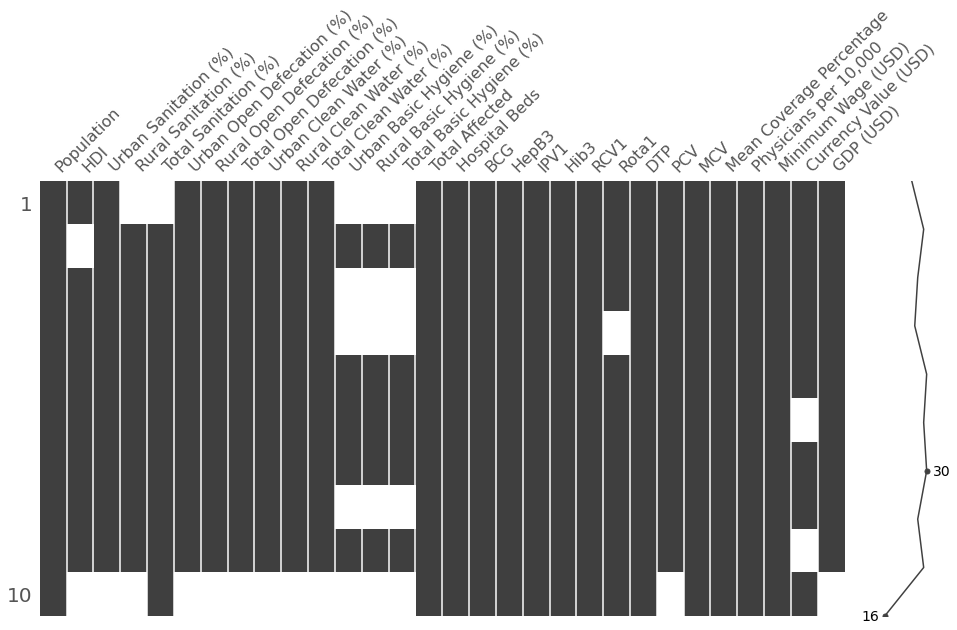

In [265]:
mso.matrix(df_latin_america, figsize=(16,8))

In [259]:
chi_square_value, p_value = calculate_bartlett_sphericity(df_latin_america)
chi_square_value, p_value

/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


(nan, nan)